Loading Women's Data...
Using columns: b3_01, m2a_1, m2b_1, m2c_1


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_1136/1076895011.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = df['v005'] / 1000000.0


Found 6143 mothers with a birth in the last 5 years.
                   Skilled ANC %
Location                        
Rwamagana                     99
Nyagatare                     96
Gatsibo                       98
Kayonza                       98
Kirehe                        97
Ngoma                         98
Bugesera                      98
East Province                 98
Rwanda (National)             98
✅ Success! The data should no longer be 0.


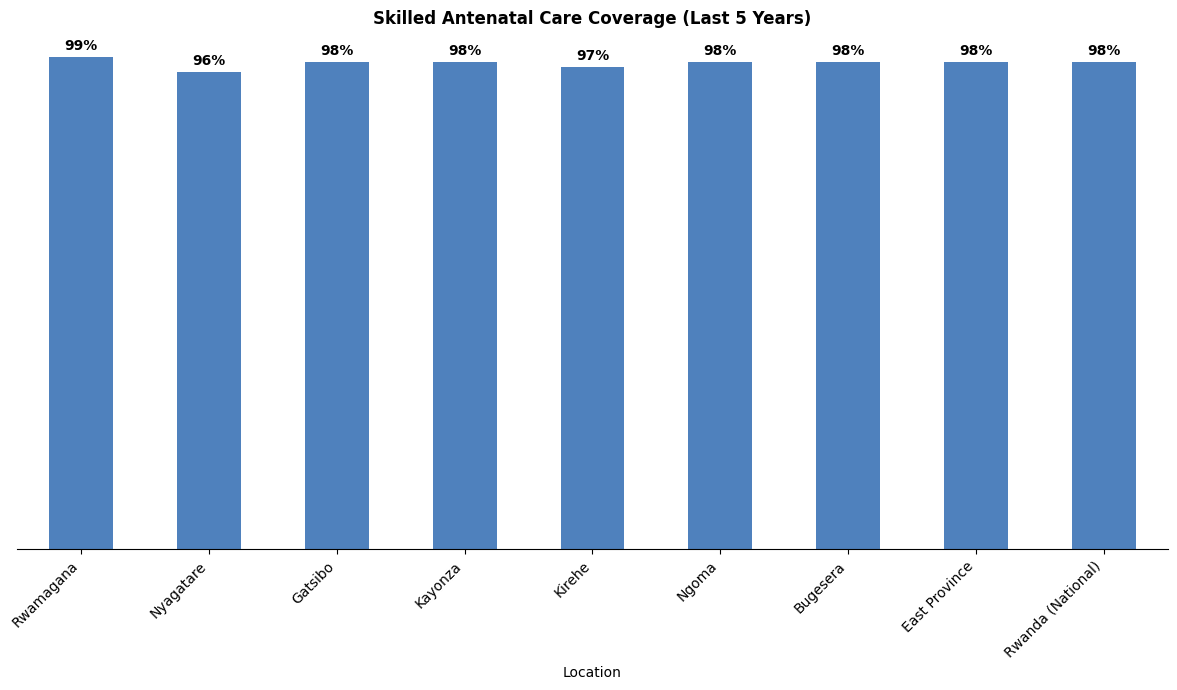

In [1]:
#!/usr/bin/env python3
# dhs_skilled_anc_robust.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    return int(math.floor(n + 0.5))

def get_anc_pct(df):
    if df.empty or df['w'].sum() == 0:
        return 0
    # Skilled if Doctor, Nurse, or Med Assistant is 1
    raw_pct = np.average(df['skilled_anc'] == 1, weights=df['w']) * 100
    return standard_round(raw_pct)

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- ROBUST COLUMN DETECTION ---
    # Detect if columns use _1 or _01
    b3_col = 'b3_01' if 'b3_01' in df.columns else 'b3_1'
    m2a = 'm2a_1' if 'm2a_1' in df.columns else 'm2a_01'
    m2b = 'm2b_1' if 'm2b_1' in df.columns else 'm2b_01'
    m2c = 'm2c_1' if 'm2c_1' in df.columns else 'm2c_01'
    dist_col = 'sdistrict' if 'sdistrict' in df.columns else 'sdstr'

    print(f"Using columns: {b3_col}, {m2a}, {m2b}, {m2c}")

    # --- FORCED NUMERIC ---
    # Convert dates and providers to numeric to prevent math errors
    for col in [b3_col, m2a, m2b, m2c, 'v008', 'v005', 'v024']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # --- FILTERS ---
    # 1. Weight
    df['w'] = df['v005'] / 1000000.0

    # 2. Birth in last 5 years (60 months)
    # Filter for women who had a birth in the 5 year window
    df = df[(df['v008'] - df[b3_col]) < 60].copy()
    print(f"Found {len(df)} mothers with a birth in the last 5 years.")

    if len(df) == 0:
        print("❌ Error: No births found in the last 60 months. Check column 'v008' and birth dates.")
        exit()

    # 3. Skilled Provider Logic
    # 1 = Yes. Note: In some files 1.0 is used.
    df['skilled_anc'] = (
        (df[m2a] == 1) | 
        (df[m2b] == 1) | 
        (df[m2c] == 1)
    ).astype(int)

    # --- AGGREGATION ---
    results = {}
    
    # Filter Eastern Province (Region 5)
    df_east = df[df['v024'] == 5].copy()
    
    for d_code, d_name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == d_code]
        results[d_name] = get_anc_pct(subset)

    results["East Province"] = get_anc_pct(df_east)
    results["Rwanda (National)"] = get_anc_pct(df)

    final_df = pd.DataFrame(list(results.items()), columns=["Location", "Skilled ANC %"]).set_index("Location")
    print(final_df)

    # JSON Output
    with open("eastern_skilled_anc_robust.json", "w") as f:
        json.dump(final_df["Skilled ANC %"].to_dict(), f, indent=4)

    # Plot
    ax = final_df.plot(kind="bar", color="#4F81BD", figsize=(12, 7), legend=False)
    plt.title("Skilled Antenatal Care Coverage (Last 5 Years)", fontweight="bold")
    plt.xticks(rotation=45, ha='right')
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    for c in ax.containers:
        ax.bar_label(c, fmt='%d%%', padding=3, fontweight="bold")
    plt.tight_layout()
    plt.savefig("Skilled_ANC_Robust.png", dpi=300)
    print("✅ Success! The data should no longer be 0.")